# ADM- HW4

In [1]:
from functions import *

## Exercise 1: Hashing

For this exercise we were asked to implement a hash function and an algorithm called HyperLogLog (HLL), and test them on a specific dataset.

### 1.1 Hash Function

A hash function is any function that can be used to map data of arbitrary size to fixed-size values.\
A good hashing function distributes the input values evenly over the selected range, while ensuring that the so called collisions are not frequent.\
Our implementation follows these steps:

1. initialize a variable ('ans') to 0;
2. for each character in the string:\
    2.1 multiply 'ans' by a prime number (31 in our case);\
    2.2 convert the character to its Unicode integer representation;\
    2.3 add the integer representation to 'ans';
3. apply a modulo operation on 'ans', using the first prime number after 2^32 as modulus;
4. convert the result of the previous operation into a 32 bit binary string.

Step 2 allows us to get a pseudo random integer for each string, while the modulo operation distributes the values over 2^32 slots.

(you can find our implementation in the **functions.py** file)

### 1.2 HyperLogLog

HyperLogLog is an algorithm for the count-distinct problem, approximating the number of distinct elements in a multiset. It can be useful when dealing with huge datasets or in general when a precise estimate would be too expensive in terms of running time and memory usage.

The intuition behind this algorithm is that the cardinality of the multiset can be estimated by calculating the maximum number of leading zeros in the binary representation of each number in the set: the higher is the cardinality of the multiset, the higher the maximum number of leading zeros that we expect to find.\
The input values are processed in buckets called registers that only keep track of the maximum number of leading zeros seen so far, then the maximum length of the leading zeros sequence for each register is used to estimate the cardinality.

We decided to select the first 12 bits of the hashed inputs to identify the register, which means that we have 2^12 registers in total.

Our implementation can be split in two parts:
1. Registers processing
2. Cardinality estimation

In part 1, we read the dataset sequentially, applying the hash function on each row, identifying the corresponding register and counting the leading zeros. We update the maximum value for each register every time we find a maximum.

In part 2, we compute the harmonic mean of the maximum leading zeros and do some other mathematical operations to estimate the cardinality.

As we can see the estimated value is 125,846,739.

We also know, from experimental results, that the expected error is $\frac{1.3}{\sqrt{m}}$ where m is the number of registers. In our case, that equals to around 4 %.

*Bonus: we also calculated the precise estimate using a more powerful machine (32 GB RAM AWS EC2 instance) and the result was 25.000.000. Our estimate is very close to that value and the error is well within the expected range.

In [ ]:
registers = createRegisters()

In [ ]:
process_data(registers)

In [ ]:
hyperLogLog(registers)

In [ ]:
error_rate()

## Exercise 2: Clustering

For this exercise we were asked to implement a k-means algorithm from scratch and use it to cluster the products from a fine foods reviews dataset.

We are only interested on the plain text of the reviews.

### 2.1 Preprocessing

In [2]:
df = pd.read_csv('./Reviews.csv', sep=",", usecols = [i for i in range(1,10)])

In [3]:
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,1.743817,2.22881,4.183199,1.296257e+09
std,7.636513,8.28974,1.310436,4.804331e+07
min,0.000000,0.00000,1.000000,9.393408e+08
25%,0.000000,0.00000,4.000000,1.271290e+09
50%,0.000000,1.00000,5.000000,1.311120e+09
75%,2.000000,2.00000,5.000000,1.332720e+09
max,866.000000,923.00000,5.000000,1.351210e+09


We drop some anomalous data:

In [5]:
df = df.drop_duplicates(subset=["UserId","ProfileName","Time","Text"], keep='first', inplace=False)
df = df[df["HelpfulnessNumerator"] <= df["HelpfulnessDenominator"]] # remove the numerator greater than denominator

We fill the null values with 0:

In [6]:
df.isnull().sum()

ProductId                  0
UserId                     0
ProfileName               11
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    3
Text                       0
dtype: int64

In [7]:
df['ProfileName'].fillna('', inplace=True)
df['Summary'].fillna('', inplace=True)

In [8]:
df.isnull().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

We create a new dataframe from the first one, grouping by productId and concatenating the text column for each review.

In [9]:
product_id_df = groupby_productid_df(df)

For each product, we apply some nlp techniques (e.g. remove stopwords).

In [10]:
product_id_df["reviews"] = [clean_text(x) for x in list(product_id_df["reviews"])]
product_id_df.head()

,ProductId,reviews
0,0006641040,"[day, person, say, chicken, soup, probabl, go,..."
1,141278509X,"[product, archer, farm, best, drink, mix, ever..."
2,2734888454,"[dog, love, chicken, product, china, wont, buy..."
3,2841233731,"[book, easi, read, ingredi, avail, store, unli..."
4,7800648702,"[came, huge, tin, much, bigger, expect, cooki,..."


We now convert our dataframe in a sparse matrix with the tfidf scores, removing the least frequent words.

In [11]:
tfidf = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, min_df = 0.01)
tfidf_matrix = tfidf.fit_transform(product_id_df["reviews"])

We are left with 1,730 distinct words

In [12]:
len(tfidf.vocabulary_)

1730

We convert the sparse matrix to a DataFrame to visualize the tfidf scores.

In [13]:
tfidf_matrix = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix)

In [14]:
tfidf_matrix

,0,1,2,3,4,5,6,7,8,9,...,1720,1721,1722,1723,1724,1725,1726,1727,1728,1729
0,0.013453,0.006685,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.010785,...,0.0,0.007167,0.0,0.010671,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.191613,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67619,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
67620,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
67621,0.000000,0.000000,0.330778,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
67622,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


We now apply the SVD method to reduce the dimensionality of our dataset to 350 components. As we can see, the explained variance is just above 60 %.

In [15]:
svd = TruncatedSVD(n_components=350)
preprocessed_data = svd.fit_transform(tfidf_matrix)
print(svd.explained_variance_ratio_.sum()*100)

61.051306217470724


We are now ready to implement our kmeans algorithm and run it on our data.

### 2.2 Kmeans implementation

Our model works like this:

1. We first specify how many clusters we want (k);
2. We randomly select k data points from our sparse matrix (after SVD) and set them as the first centroids;
3. We iterate over each data point in our sparse matrix, calculating the distance from each centroid and assigning the data point to the closest centroid (for each centroid we have a cluster);
4. We take the average of all points in each cluster, finding the coordinates of our new centroids;
5. We repeat step 3-4 until the clusters stop changing (or until we reach 100 iterations).

Our implementation uses Python OOP (object oriented programming). See **functions_final.py** for the source code.

We first create an instance of our Kmeans model:

In [16]:
model_test = my_Kmeans(5)

Then we use a method to fit the model and output a list of the cluster labels for each data point

In [17]:
cluster_labels = model_test.fit(preprocessed_data)

iteration no. 0
iteration no. 1
iteration no. 2
iteration no. 3
iteration no. 4
iteration no. 5
iteration no. 6
iteration no. 7
iteration no. 8
iteration no. 9
iteration no. 10
iteration no. 11
iteration no. 12
iteration no. 13
iteration no. 14
iteration no. 15
iteration no. 16
iteration no. 17
iteration no. 18
iteration no. 19
iteration no. 20
iteration no. 21
iteration no. 22
iteration no. 23
iteration no. 24
iteration no. 25
iteration no. 26
iteration no. 27
iteration no. 28
iteration no. 29
iteration no. 30
iteration no. 31
iteration no. 32
iteration no. 33
iteration no. 34
iteration no. 35
iteration no. 36
iteration no. 37
iteration no. 38


After 73 iterations the algortithm converged. Let's see the labels:

In [18]:
cluster_labels[:10]

[0, 0, 1, 0, 0, 1, 0, 0, 0, 0]

We are now interested in finding the optimal number of cluster. To do so, we use the so called Elbow Method.

To apply this method we first need to compute, for different number of clusters, the sum of the squared distance between each point and its closest centroid.

We created a method called 'inertia' inside our Kmeans class that performs this operation after fitting the model.  

In [88]:
elbow = {}

for i in range (5,70,5):
    print('k = {0}'.format(i))
    model_test = Kmeans(i)
    result = model_test.fit(new_dn)
    elbow[i] = model_test.inertia(new_dn)

k = 5
iteration no. 0
iteration no. 1
iteration no. 2
iteration no. 3
iteration no. 4
iteration no. 5
iteration no. 6
iteration no. 7
iteration no. 8
iteration no. 9
iteration no. 10
iteration no. 11
iteration no. 12
iteration no. 13
iteration no. 14
iteration no. 15
iteration no. 16
iteration no. 17
iteration no. 18
iteration no. 19
iteration no. 20
iteration no. 21
iteration no. 22
iteration no. 23
iteration no. 24
k = 10
iteration no. 0
iteration no. 1
iteration no. 2
iteration no. 3
iteration no. 4
iteration no. 5
iteration no. 6
iteration no. 7
iteration no. 8
iteration no. 9
iteration no. 10
iteration no. 11
iteration no. 12
iteration no. 13
iteration no. 14
iteration no. 15
iteration no. 16
iteration no. 17
iteration no. 18
iteration no. 19
iteration no. 20
iteration no. 21
iteration no. 22
iteration no. 23
iteration no. 24
iteration no. 25
iteration no. 26
iteration no. 27
iteration no. 28
iteration no. 29
iteration no. 30
iteration no. 31
iteration no. 32
iteration no. 33
iter

We can now use a line plot to visualize the relations between the number of clusters and the sum of the squared distance:

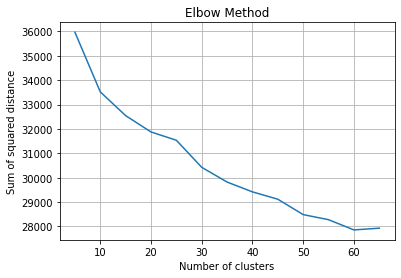

In [36]:
showElbow(elbow)

The optimal number of clusters can be derived from the inflection point of the plot above, which in our case seems to be 10 clusters.

Let's now run our model with 10 clusters:

In [19]:
model_test = my_Kmeans(10)
cluster_labels = model_test.fit(preprocessed_data)

iteration no. 0
iteration no. 1
iteration no. 2
iteration no. 3
iteration no. 4
iteration no. 5
iteration no. 6
iteration no. 7
iteration no. 8
iteration no. 9
iteration no. 10
iteration no. 11
iteration no. 12
iteration no. 13
iteration no. 14
iteration no. 15
iteration no. 16
iteration no. 17
iteration no. 18
iteration no. 19
iteration no. 20
iteration no. 21
iteration no. 22
iteration no. 23
iteration no. 24
iteration no. 25
iteration no. 26
iteration no. 27
iteration no. 28
iteration no. 29
iteration no. 30
iteration no. 31
iteration no. 32
iteration no. 33
iteration no. 34
iteration no. 35
iteration no. 36
iteration no. 37
iteration no. 38
iteration no. 39
iteration no. 40
iteration no. 41
iteration no. 42
iteration no. 43
iteration no. 44
iteration no. 45
iteration no. 46
iteration no. 47
iteration no. 48
iteration no. 49


### 2.3 Comparison with SkLearn KMeans++

We now want to compare our results with the KMeans++ implemented in SkLearn

Let's first run the built-in algorithm

In [20]:
model = KMeans(init = 'k-means++', n_clusters = 10)
slice = preprocessed_data[:]
model.fit(slice)
kmeans_plusplus_labels = model.predict(slice)

Then we use our function to display for each kmeans++ cluster, a list of the percentage of matching points for each of our clusters.

As we can see, for cluster 9 of KMeans++, around 96 % of the points have been assigned to our 1rd cluster and so on.

In [21]:
compare_models(cluster_labels, kmeans_plusplus_labels)

{6: [96.54, 0.12, 0.0, 2.35, 0.0, 0.04, 0.0, 0.7, 0.0, 0.25],
 1: [12.54, 78.32, 0.18, 3.52, 0.0, 1.45, 0.0, 0.01, 0.15, 3.82],
 0: [0.0, 0.03, 97.46, 2.39, 0.0, 0.03, 0.0, 0.0, 0.03, 0.06],
 2: [13.54, 3.01, 0.31, 81.46, 0.0, 0.39, 0.01, 0.0, 0.22, 1.05],
 5: [0.0, 0.17, 0.0, 0.13, 99.67, 0.0, 0.0, 0.0, 0.02, 0.0],
 4: [0.0, 0.26, 0.0, 0.67, 0.0, 20.52, 0.0, 0.0, 78.4, 0.15],
 8: [0.0, 0.18, 0.0, 0.13, 0.0, 0.0, 99.5, 0.0, 0.18, 0.0],
 7: [0.06, 0.06, 95.28, 4.47, 0.06, 0.0, 0.0, 0.06, 0.0, 0.0],
 9: [0.04, 13.24, 0.04, 76.32, 0.15, 5.58, 0.38, 0.0, 4.19, 0.08],
 3: [5.49, 0.05, 0.0, 0.18, 0.0, 0.0, 0.0, 94.23, 0.05, 0.0]}

In general, our model returns clusters that are quite similar.

### 2.4 Identify the kind of products in the cluster (e.g., chips, tea, coffee) using a visualization called word cloud.

After inserting the "cluster" column into the last dataset where per each product there is the reviews tokenizes

In [22]:
new_df = addClusterColumn(product_id_df, cluster_labels)
new_df.head()

,ProductId,reviews,cluster
0,0006641040,"[day, person, say, chicken, soup, probabl, go,...",0
1,141278509X,"[product, archer, farm, best, drink, mix, ever...",1
2,2734888454,"[dog, love, chicken, product, china, wont, buy...",2
3,2841233731,"[book, easi, read, ingredi, avail, store, unli...",1
4,7800648702,"[came, huge, tin, much, bigger, expect, cooki,...",1


Now, we grouped for clusters the tokens present in each ProductId that belongs to its cluster.

In [23]:
new_dp = ListTokenPerCluster(new_df)
new_dp

,reviews
0,"[[day, person, say, chicken, soup, probabl, go..."
1,"[[product, archer, farm, best, drink, mix, eve..."
2,"[[dog, love, chicken, product, china, wont, bu..."
3,"[[product, avail, http, www, amazon, com, vict..."
4,"[[purchas, product, recent, teenag, recur, ast..."
5,"[[review, state, high, fructos, corn, syrup, w..."
6,"[[one, favorit, place, frequent, afford, nice,..."
7,"[[stuff, rock, egg, chili, highli, recomend, p..."
8,"[[start, seed, indoor, earli, march, harden, f..."
9,"[[sinc, move, us, england, coupl, food, item, ..."


We represented each cluster in a word cloud visualization

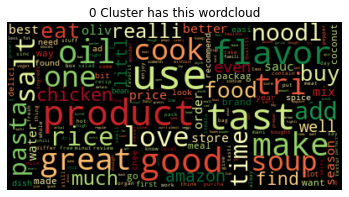

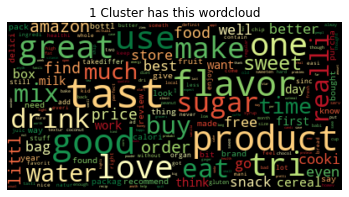

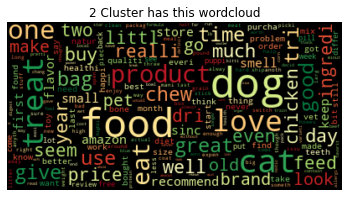

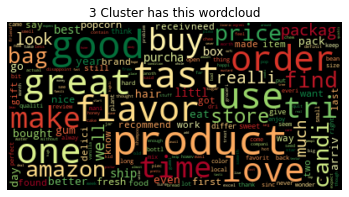

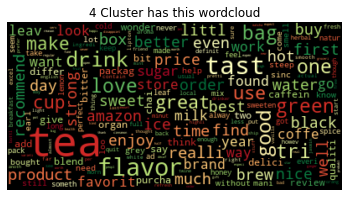

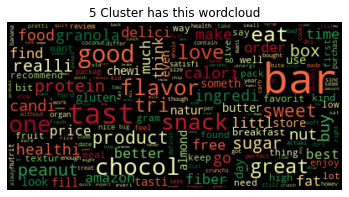

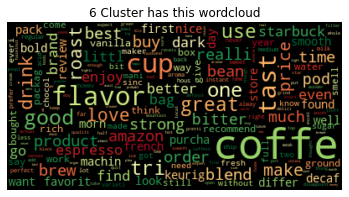

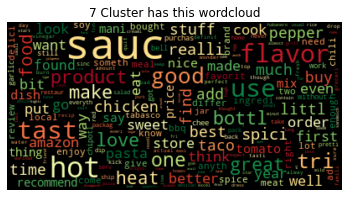

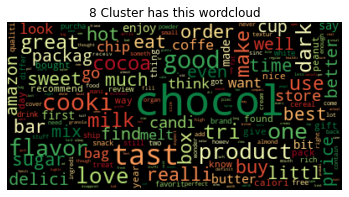

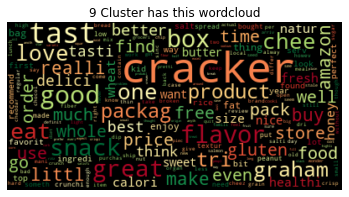

In [24]:
show_word_clouds(new_dp)

### 2.5 Provide the number of product in each cluster

We create a method that return the number of products present in each cluster. This allows us to understand how much observations are in each cluster.

In [25]:
numberOfProduct(cluster_labels)

Show the number of products per each cluster: 

The cluster 0 has 8222 products
The cluster 1 has 11224 products
The cluster 2 has 4991 products
The cluster 3 has 27810 products
The cluster 4 has 4600 products
The cluster 5 has 1159 products
The cluster 6 has 3823 products
The cluster 7 has 2063 products
The cluster 8 has 2910 products
The cluster 9 has 822 products


### 2.6 Compute the reviews' score distribution in each cluster. Once you get them, test if their mean differences are statistically significant!

The operation request in this sub question is pretty similar to the initially sub question. We want to add in the new_df the Scores of each product in order to plot the Score distribution for each cluster.

In [32]:
score_distributions = dataset_score(new_df, df)

score_distributions.head()

,ProductId,cluster,Score
0,0006641040,0,4
1,0006641040,0,5
2,0006641040,0,3
3,0006641040,0,5
4,0006641040,0,1


Show for each cluster the score distributions.

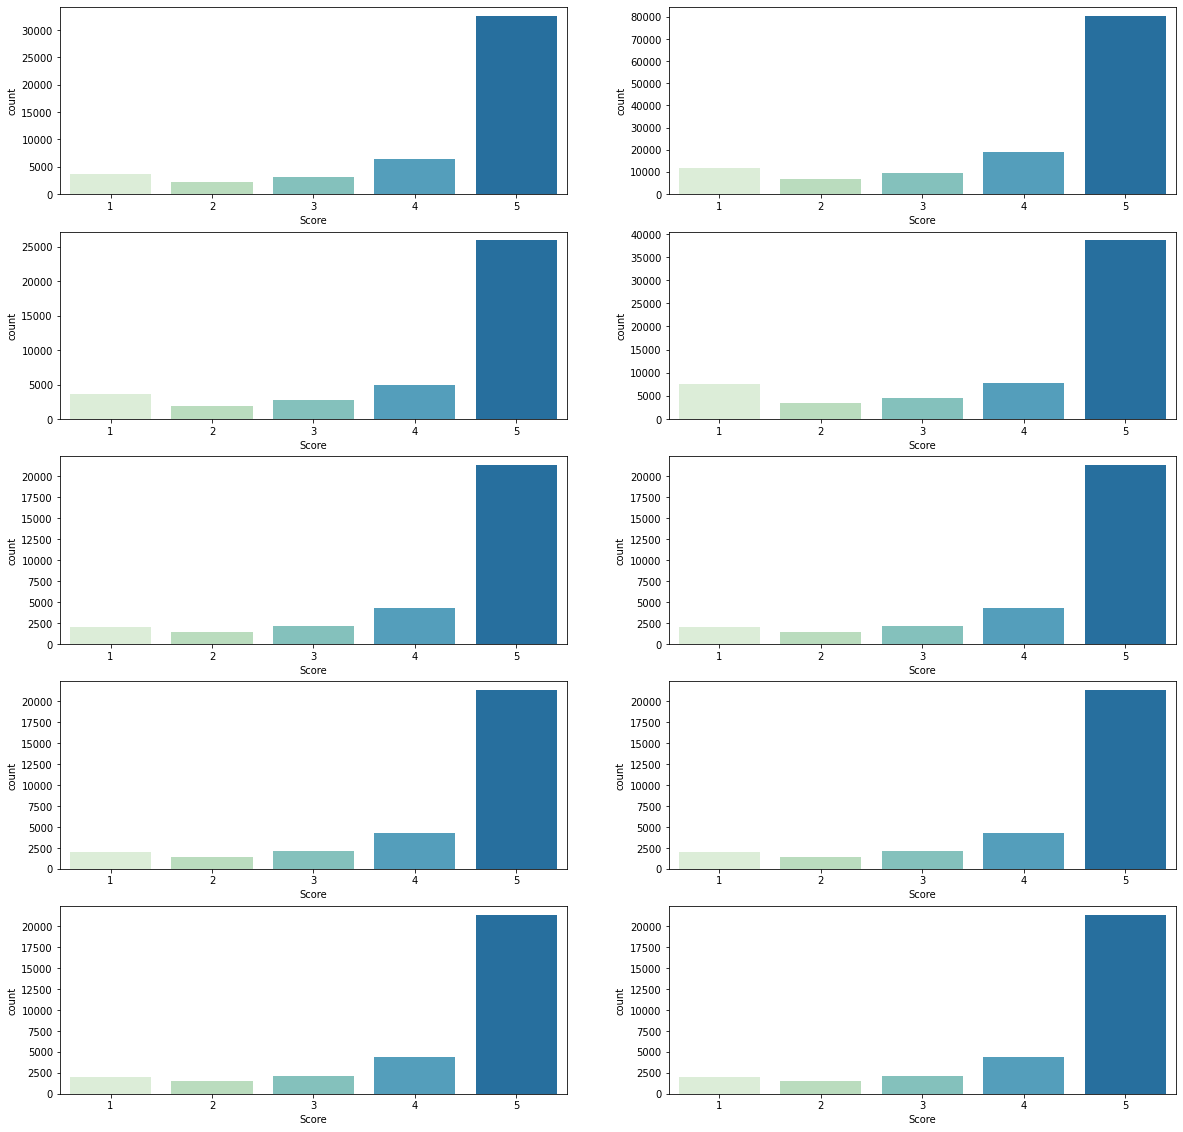

In [43]:
showPlotScoreDistribution(score_distributions)

Just by looking at the plots, we don't see any significant differences in the scores between clusters.

### 2.7 Get the number of unique users writing reviews in each cluster

Count for each cluster the number of unique users in order to solve the professors requests.

In [36]:
uniq_users = usersWritingCluster(new_df, df)
uniq_users

cluster
0    37340
1    93905
2    30364
3    53314
4    25175
5     9728
6    33670
7     7624
8    15265
9     4798
Name: UserId, dtype: int64

## Bonus

### KMeans with MapReduce

### Dynamically visualize the clustering evolution after each iteration

In [37]:
result = model_test.fit_for_plot(np.array(preprocessed_data))

iteration no. 0
iteration no. 1
iteration no. 2
iteration no. 3


In [ ]:
l = list(result.values())
k = 4
n = 2

randomlistX = [np.random.normal(i+5*i, 1) for i in l[-1]]
randomlistY = [np.random.normal(((i+5*i)%n), 1) for i in l[-1]]

df2 = pd.DataFrame()
cluster = []
iteration = []

for i, cluster_list in enumerate(l):
    cluster += cluster_list
    iteration += [i]*len(cluster_list)

    
df2['x'] = randomlistX*len(l)
df2['y'] = randomlistY*len(l)


df2['iteration'] = iteration
df2['cluster'] = cluster

px.scatter(df2, x = 'x',y = 'y', animation_frame = 'iteration',color = 'cluster')

## 3. Algorithmic question

For this exercise we were asked to prove that we can sort an array A, containing n integer numbers, in time O(n + r), where r = max[a] - min[a].\
(both min[a] and max[a] are given)

The sorting algorithm that accomplish this is called **Counting Sort**.

This algorithm works by iterating through the input, counting the number of times each item occurs, and using those counts to compute an item's index in the final, sorted array.

A simple implementation is shown below:

In [9]:
import random

# generate a random array
my_array = [random.randint(0, 10) for i in range(10)]

# compute the max and min values
max_val = max(my_array)
min_val = min (my_array)

print('A = {0}, min[A] = {1}, max[A] = {2}\n'.format(my_array, min_val, max_val))


def counting_sort(my_array, max_val, min_val):

    max_min_range = max_val - min_val

    # initialize two empty arrays
    count = [0] * (max_min_range + 1) # O(max_min_range)
    output = [0] * len(my_array)      # O(n)
    
    # count the occurence of each different integer
    for i in range(len(my_array)):    # O(n)
        count[my_array[i] - min_val] += 1
    
    # iterate over the count array and cumulate the no. of occurences
    for i in range(1, len(count)):    # O(max_min_range)
         count[i] += count[i-1]

    # for each array element, get from the count array the sorted index
    for i in range (len(my_array)):   # O(n)
        output[count[my_array[i] - min_val]-1] = my_array[i]
        #update the count array
        count[my_array[i] - min_val] -= 1

    return output
    
sorted_array = counting_sort(my_array, max_val, min_val)
print('A_sorted = {0}'.format(sorted_array))

A = [1, 5, 3, 7, 6, 8, 0, 9, 5, 3], min[A] = 0, max[A] = 9

A_sorted = [0, 1, 3, 3, 5, 5, 6, 7, 8, 9]


We can see that we have 2 for loops that requires O(n), 1 that requires O(r) and two arrays initialization that require O(n) and O(r) respectively.

The overall complexity is therefore O(n + r)

Counting sort is efficient if the range of input data is not significantly greater than the length of the array.